# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize

In [3]:
import sys
sys.path.append("../smote_cd/")
from smote_cd.dataset_generation import softmax

In [4]:
import dirichlet_regression

# Creation of the simulated data

In [5]:
n = 2000 #nb of points
K = 2 #nb of features
J = 2 #nb of classes

In [6]:
X = np.random.normal(size=(n,K))

In [7]:
beta = np.random.randint(low=-5, high=5, size=(K,J))
beta[:,0] = 0
beta = np.array(beta,dtype=float)

In [8]:
beta

array([[ 0.,  4.],
       [ 0., -3.]])

In [11]:
rho=-0.5

neighbors = NearestNeighbors(n_neighbors=6).fit(X)
W = neighbors.kneighbors_graph(X).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/5

Minv = np.linalg.inv(np.identity(n) - rho*W)

mu = dirichlet_regression.compute_mu_spatial(X, beta, rho=rho, W=W, Minv=Minv)

In [12]:
#Z = np.ones(np.shape(X))
#Z[:,1] += 1
Z = np.copy(X)
gamma_var = np.zeros(K)
phi = np.exp(np.matmul(Z,gamma_var))

#phi = np.ones(X.shape[0])

In [13]:
alpha = np.copy(mu)
for i in range(mu.shape[-1]):
    alpha[:,i] = phi*mu[:,i]

In [14]:
Y = np.zeros((n,J))
for i in range(n):
    Y[i] = np.random.dirichlet(alpha[i])

In [15]:
Y_star = (Y*(n-1)+1/J)/n

# Defining the functions

In [17]:
def f(x, X, Y, Z, W):
    beta = x[:K*J].reshape((K,J))
    gamma_var = x[K*J:-1]
    rho = x[-1]
    mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    #alpha = np.copy(mu)
    #for i in range(mu.shape[-1]):
    #    alpha[:,i] = phi*mu[:,i]
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y)

In [23]:
%%time
f(np.concatenate([beta.flatten(),gamma_var,[rho]]), X, Y_star, Z, W)

Wall time: 332 ms


-4094.1194018784354

In [33]:
def fprime(x, X, Y, Z, W):
    n = X.shape[0]
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    Xtilde = np.matmul(Minv,X)
    beta_grad = dirichlet_regression.dirichlet_gradient(mu, Xtilde, Y)
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, Xtilde, Y, Z)
    rho_der = dirichlet_regression.dirichlet_derivative_wrt_rho(mu, phi, Minv, beta, W, X, Y, Z)
    return(np.concatenate([beta_grad.flatten(),gamma_grad,[rho_der]]))

In [34]:
%%time
fprime(np.concatenate([beta.flatten(),gamma_var,[rho]]), X, Y_star, Z, W)

Wall time: 797 ms


array([  611.0566915 ,  -611.0566915 ,  -449.08605836,   449.08605836,
          55.17680862,   -25.72452237, -2490.30741725])

In [39]:
beta0 = np.array([ [0., 1.], [0., -1.] ])
gamma_var0 = np.array([0.,0.])
rho0 = -0.1

In [40]:
%%time
solution=scipy.optimize.root(fprime, np.concatenate([beta0.flatten(),gamma_var0,[rho0]]), args=(X, Y_star, Z, W))

Wall time: 1min 18s


In [41]:
print(solution.message)
solution.x

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


array([ 0.        ,  2.16876404,  0.        , -1.59003733,  0.01478709,
        0.0044226 , -0.76470893])

In [43]:
fprime(solution.x,X,Y_star,Z,W)

array([ 2.08608425, -2.08608425, -1.57542595,  1.57542595,  0.17047142,
       -0.06871044,  3.48366874])

In [44]:
print("Likelihood with real parameters:", -f(np.concatenate([beta.flatten(),gamma_var,[rho]]), X, Y_star, Z,W))
print("Likelihood with estimated parameters:",-f(solution.x,X,Y_star,Z,W))

Likelihood with real parameters: 4094.1194018784354
Likelihood with estimated parameters: 5367.620738641471


In [45]:
mu_sol = dirichlet_regression.compute_mu_spatial(X, solution.x[:K*J].reshape(np.shape(beta)), solution.x[-1], W)

gamma_var_sol = solution.x[K*J:-1]
phi_sol = np.exp(np.matmul(Z,gamma_var_sol))

alpha_sol = np.copy(mu_sol)
for i in range(mu_sol.shape[-1]):
    alpha_sol[:,i] = phi_sol*mu_sol[:,i]

In [46]:
beta

array([[ 0.,  4.],
       [ 0., -3.]])

In [47]:
solution.x[:K*J].reshape(np.shape(beta))

array([[ 0.        ,  2.16876404],
       [ 0.        , -1.59003733]])

In [48]:
dirichlet_regression.dirichlet_loglikelihood(mu, phi, Y_star)

4094.1194018784354

In [49]:
dirichlet_regression.dirichlet_loglikelihood(mu_sol, phi, Y_star)

5367.436936626789

In [60]:
beta1 = np.linspace(0, 5, 25)
beta2 = np.linspace(0, 5, 25)
beta1v, beta2v = np.meshgrid(beta1, beta2)

In [61]:
%%time
list_loglikelihood = []
for b1, b2 in zip(beta1v.flatten(), beta2v.flatten()):
    beta_temp = np.array([[0.,b1],[0.,b2]])
    mu_temp = dirichlet_regression.compute_mu(X,beta_temp)
    list_loglikelihood.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp, phi, Y_star))

Wall time: 58 s


<IPython.core.display.Javascript object>


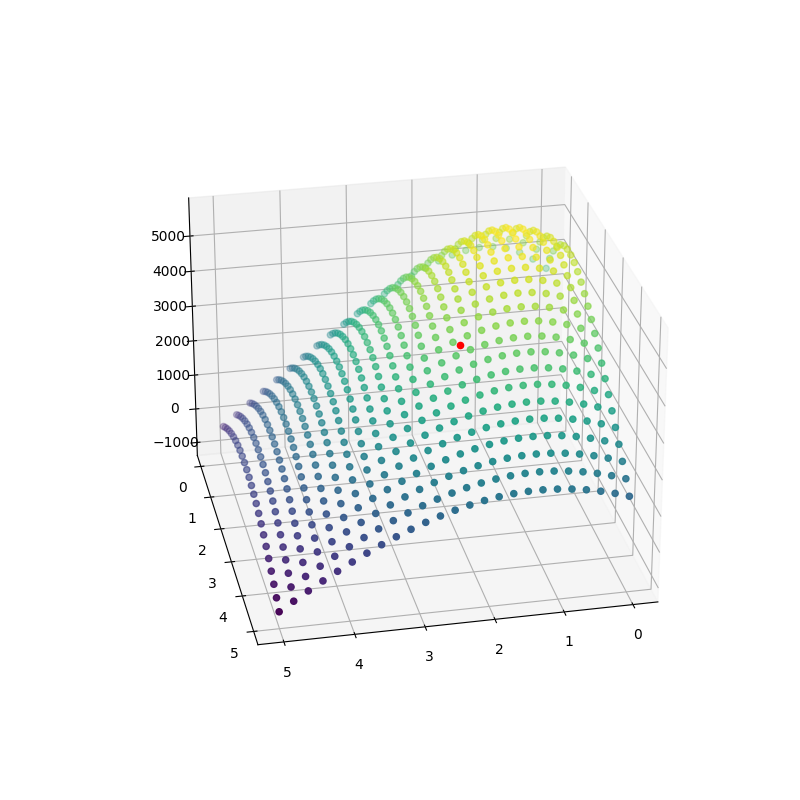

In [63]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection ='3d')
ax.scatter3D(beta1v.flatten(), beta2v.flatten(), np.array(list_loglikelihood), c=list_loglikelihood)
ax.scatter3D(2,3,dirichlet_regression.dirichlet_loglikelihood(mu, phi, Y_star), c='red')
plt.show()

In [83]:
%%time
list_ll = []
for b1, b2 in zip(beta1v.flatten(), beta2v.flatten()):
    beta_temp = np.array([[0.,b1],[0.,b2]])
    mu_temp = dirichlet_regression.compute_mu(X,beta_temp)
    list_ll.append(dirichlet_ll(mu_temp, Y, epsilon=1e-200))

Wall time: 32.2 s


<IPython.core.display.Javascript object>


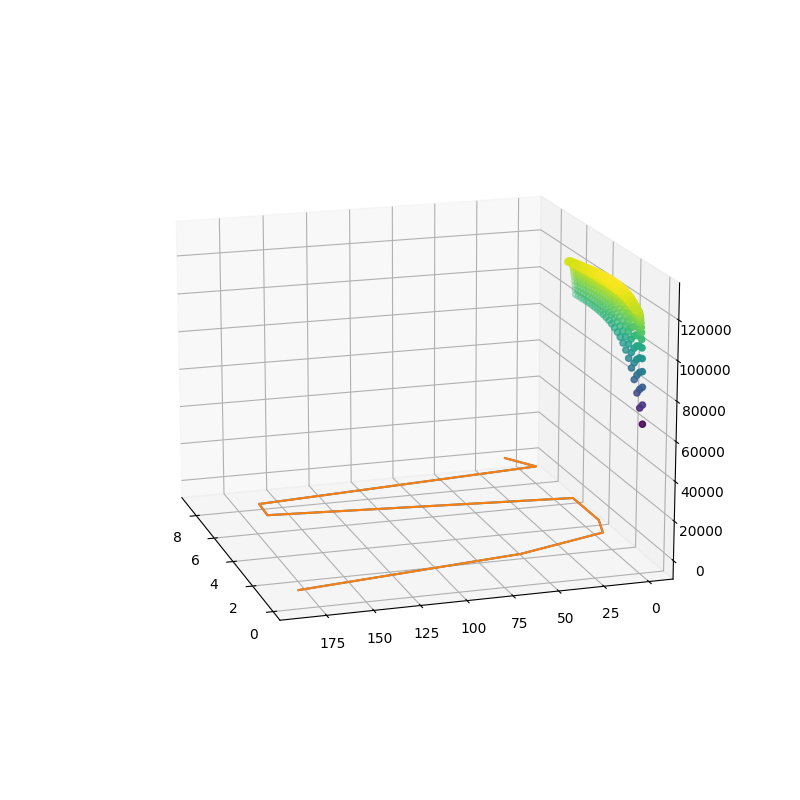

In [86]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection ='3d')
ax.scatter3D(beta1v.flatten(), beta2v.flatten(), np.array(list_ll), c=list_ll)
ax.scatter3D(2,3,dirichlet_ll(mu, Y, epsilon=1e-200), c='red')
plt.show()

In [ ]:
%matplotlib inline

In [196]:
r2_score(Y_star,mu)

0.8353095849897278

In [202]:
r2_score(Y_star,mu_sol)

0.713461686937251

### Test optimize functions

In [392]:
%%time
correct_derivative = dirichlet_regression.dirichlet_second_derivative_beta_gamma(mu, phi, beta, X, Y_star, Z)
correct_derivative

Wall time: 1.21 s


array([[[ 2996.88906428, -1378.42208329, -1618.46698099],
        [  330.13866041,  4145.73109176, -4475.86975217]],

       [[ 5993.77812855, -2756.84416657, -3236.93396198],
        [  660.27732083,  8291.46218351, -8951.73950434]]])

In [413]:
def dirichlet_second_derivative_beta_gamma_2(mu, phi, beta, X, Y, Z, epsilon=0):
    K = np.shape(X)[1]
    J = np.shape(Y)[1]
    n = np.shape(Y)[0]
    derivatives = np.zeros((K,K,J))
    for i in range(n):
        digamma_phi_mu = digamma(phi[i]*mu[i])
        trigamma_phi_mu = polygamma(1,phi[i]*mu[i])
        logYi = np.log(Y[i]+epsilon)
        sum_temp = np.sum(mu[i]*(logYi - digamma_phi_mu - mu[i]*phi[i]*trigamma_phi_mu))
        phi_Z_i = phi[i]*Z[i,:]
        for d in range(J):
            temp_d = mu[i,d]*( logYi[d] - digamma_phi_mu[d] - mu[i,d]*phi[i]*trigamma_phi_mu[d] - sum_temp )
            for p in range(K):
                derivatives[:,p,d] += phi_Z_i*X[i,p]*temp_d
    return(derivatives)

In [414]:
%%time
new_derivative = dirichlet_second_derivative_beta_gamma_2(mu, phi, beta, X, Y_star, Z)
new_derivative

Wall time: 615 ms


array([[[ 2996.88906428, -1378.42208329, -1618.46698099],
        [  330.13866041,  4145.73109176, -4475.86975217]],

       [[ 5993.77812855, -2756.84416657, -3236.93396198],
        [  660.27732083,  8291.46218351, -8951.73950434]]])

In [415]:
np.round(new_derivative,10) == np.round(correct_derivative,10)

array([[[ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True]]])

### With hessian

In [382]:
def fhessian(x, X, Y, Z):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    hessian = np.zeros((K*J+K,K*J+K))
    beta_hess = dirichlet_regression.dirichlet_hessian_wrt_beta(mu, phi, X, Y).reshape((K*J,K*J))
    gamma_hess = dirichlet_regression.dirichlet_hessian_wrt_gamma(mu, phi, beta, X, Y, Z)
    beta_gamma_derivative = dirichlet_regression.dirichlet_second_derivative_beta_gamma(mu, phi, beta, X, Y, Z).reshape((K,K*J)) 
    hessian[:K*J,:K*J] = beta_hess
    hessian[-K:,-K:] = gamma_hess
    hessian[:K*J,-K:] = beta_gamma_derivative.transpose()
    hessian[-K:,:K*J] = beta_gamma_derivative
    return(hessian)

In [416]:
%%time
hess_test = fhessian(np.concatenate([beta.flatten(),gamma_var]), X, Y_star, Z)

Wall time: 2.61 s


In [417]:
%%time
solution=scipy.optimize.root(fprime, np.concatenate([beta0.flatten(),gamma_var0]), jac=fhessian, args=(X, Y_star, Z))

Wall time: 2min 35s


In [418]:
print(solution.message)
solution.x

The solution converged.


array([ 0.        , -0.32955542, -0.33077856,  0.        ,  0.33794039,
       -0.3407747 , -1.04496719,  1.27357343])

# With Maupiti data ?

In [126]:
X_maupiti = pd.read_csv('../../Maupiti/maupiti_X_13244.csv', index_col=0)
Y_maupiti = pd.read_csv('../../Maupiti/maupiti_Y_13244.csv',index_col=0)

In [130]:
n_features = X_maupiti.shape[1]
n_classes = Y_maupiti.shape[1]
n_samples = X_maupiti.shape[0]

In [128]:
X_maupiti = np.array(X_maupiti)
Y_maupiti = np.array(Y_maupiti)

In [150]:
X_maupiti = X_maupiti/10000

In [131]:
Y_star_maupiti = (Y_maupiti*(n_samples-1)+1/n_classes)/n_samples

In [152]:
#Z_maupiti = np.ones(np.shape(X_maupiti))
Z_maupiti = np.copy(X_maupiti)

In [153]:
beta_maupiti = np.ones(n_features*n_classes+n_features)[:n_features*n_classes].reshape((n_features,n_classes))
beta_maupiti[:,0] = 0

In [154]:
X_maupiti_train = X_maupiti[3300:3900,:]
Y_star_maupiti_train = Y_star_maupiti[3300:3900,:]
Z_maupiti_train = Z_maupiti[3300:3900,:]

In [155]:
np.shape(X_maupiti_train)

(600, 16)

In [158]:
%%time
solution_maupiti=scipy.optimize.root(fprime, np.zeros(n_features*n_classes+n_features), 
                                     args=(X_maupiti_train, Y_star_maupiti_train, Z_maupiti_train))

Wall time: 1min 45s


In [159]:
print(solution_maupiti.message)
solution_maupiti.x

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.


array([ 0.00000000e+00, -1.96084433e+00, -7.81992136e-01, -8.49258440e-01,
       -8.47685420e-01, -8.52609511e-01, -1.53546700e+00, -1.03102888e-01,
       -8.59730500e-01, -9.09402212e-01,  0.00000000e+00,  3.12461741e-03,
        1.70092228e-03, -1.03746667e-05,  8.80159213e-06,  1.74557230e-05,
       -1.93813115e-03, -1.36383873e-03, -2.53479278e-05, -4.81379293e-04,
        0.00000000e+00, -2.79970834e+03, -8.58727251e+02, -2.14824646e+03,
       -2.13388049e+03, -2.14616166e+03, -3.26427386e+02, -9.77330320e+02,
       -2.18750802e+03, -2.77221881e+03,  0.00000000e+00,  1.21621773e+02,
        6.22847272e+01,  4.43052011e+01,  4.43601614e+01,  4.84378649e+01,
        3.39326851e+02,  2.03914176e+02,  5.92227339e+01,  1.53549613e+02,
        0.00000000e+00,  2.49817534e+00,  1.24127139e+00,  1.26672028e+00,
        1.26718954e+00,  1.27164501e+00,  2.08554137e+00,  1.09206379e+00,
        1.27408410e+00,  1.28210768e+00,  0.00000000e+00, -3.09443470e-03,
       -1.21925458e-03, -

In [160]:
beta_maupiti = solution_maupiti.x[:n_features*n_classes].reshape((n_features,n_classes))

In [178]:
beta_maupiti

array([[ 0.00000000e+00, -1.96084433e+00, -7.81992136e-01,
        -8.49258440e-01, -8.47685420e-01, -8.52609511e-01,
        -1.53546700e+00, -1.03102888e-01, -8.59730500e-01,
        -9.09402212e-01],
       [ 0.00000000e+00,  3.12461741e-03,  1.70092228e-03,
        -1.03746667e-05,  8.80159213e-06,  1.74557230e-05,
        -1.93813115e-03, -1.36383873e-03, -2.53479278e-05,
        -4.81379293e-04],
       [ 0.00000000e+00, -2.79970834e+03, -8.58727251e+02,
        -2.14824646e+03, -2.13388049e+03, -2.14616166e+03,
        -3.26427386e+02, -9.77330320e+02, -2.18750802e+03,
        -2.77221881e+03],
       [ 0.00000000e+00,  1.21621773e+02,  6.22847272e+01,
         4.43052011e+01,  4.43601614e+01,  4.84378649e+01,
         3.39326851e+02,  2.03914176e+02,  5.92227339e+01,
         1.53549613e+02],
       [ 0.00000000e+00,  2.49817534e+00,  1.24127139e+00,
         1.26672028e+00,  1.26718954e+00,  1.27164501e+00,
         2.08554137e+00,  1.09206379e+00,  1.27408410e+00,
         1.

In [179]:
dirichlet_regression.dirichlet_loglikelihood(mu_maupiti,phi_maupiti,Y_star_maupiti_train)

42765.570256497536

In [162]:
mu_maupiti = dirichlet_regression.compute_mu(X_maupiti_train, beta_maupiti)

gamma_var_maupiti = solution_maupiti.x[n_features*n_classes:]
phi_maupiti = np.exp(np.matmul(Z_maupiti_train,gamma_var_maupiti))

alpha_maupiti = np.copy(mu_maupiti)
for i in range(mu_maupiti.shape[-1]):
    alpha_maupiti[:,i] = phi_maupiti*mu_maupiti[:,i]

In [163]:
mu_maupiti

array([[0.11809002, 0.1189386 , 0.11864524, ..., 0.12181322, 0.08699249,
        0.09090898],
       [0.10450304, 0.16047315, 0.10317483, ..., 0.0993816 , 0.08605704,
        0.08827811],
       [0.10214822, 0.18152986, 0.10907575, ..., 0.10921186, 0.08260287,
        0.09029026],
       ...,
       [0.09538015, 0.10964309, 0.09123104, ..., 0.11468026, 0.10144162,
        0.09177161],
       [0.08512528, 0.10464929, 0.09868702, ..., 0.08692158, 0.09671544,
        0.10388354],
       [0.08414473, 0.14348648, 0.08874248, ..., 0.07664219, 0.09483817,
        0.10430192]])